In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *
from data_retrieve import *
from gbm import *

In [28]:
last_id = 287
backtest_start = 55
backtest_end = 60
h = 0.01

In [29]:
tickers = ['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']

# Getting Delta

In [58]:
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    
prices = []
h = 0.01

for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=100, drift=0.01, current_id=current_id, window_size=30, implied_volatility=True)

    old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
    old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
    old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        payoff_up[t] = []
        payoff_down[t] = []
        
    for i in range(result.shape[1]):
        path_rog = np.append(old_path_rog, result[0][i].flatten())
        path_cfr = np.append(old_path_cfr, result[1][i].flatten())
        path_zurn = np.append(old_path_zurn, result[2][i].flatten())

        normal = payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.011107, risk_neutral=True, verbose=False)
        up = payoff_func(path_rog * (1 + h), path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        down = payoff_func(path_rog * (1 - h), path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        payoff_up['ROG_Last_Price'].append(up)
        payoff_down['ROG_Last_Price'].append(down)

        up = payoff_func(path_rog, path_cfr * (1 + h), path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        down = payoff_func(path_rog, path_cfr * (1 - h), path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        payoff_up['CFR_Last_Price'].append(up)
        payoff_down['CFR_Last_Price'].append(down)

        up = payoff_func(path_rog, path_cfr, path_zurn * (1 + h), combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        down = payoff_func(path_rog, path_cfr, path_zurn * (1 - h), combined_df.iloc[current_id]['Date'], risk_free=0.01107, risk_neutral=True, verbose=False)
        payoff_up['ZURN_Last_Price'].append(up)
        payoff_down['ZURN_Last_Price'].append(down)
        payoff.append(normal)
    
    for t in tickers:
        deltas[t].append(np.exp(-0.01107 * (last_id - current_id)) * \
        np.sum(np.subtract(payoff_up[t], payoff_down[t]) / (2 * h * len(payoff_up))))
        gammas[t].append(np.exp(-0.01107 * (last_id - current_id)) * \
        np.sum(np.add(np.subtract(payoff_up[t], np.multiply(payoff, 2)), payoff_down[t]) / (h * h)))
    prices.append(np.mean(payoff))



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


In [59]:
deltas

{'ROG_Last_Price': [0.0,
  29.25304259252482,
  15.74636103449585,
  0.0,
  15.929873783550017],
 'CFR_Last_Price': [1635.1522814928014,
  1142.1996888385236,
  453.38705045415117,
  1462.2338768953703,
  613.7162704351532],
 'ZURN_Last_Price': [0.0, 0.0, 0.0, 0.0, 0.0]}

In [60]:
gammas

{'ROG_Last_Price': [5029.686967840836,
  5057.527530301128,
  5376.04438870253,
  5330.953609799645,
  5399.4897618722935],
 'CFR_Last_Price': [231769.14493334666,
  -23922.129640763014,
  204090.63555806712,
  -219119.30356976698,
  297088.9358486268],
 'ZURN_Last_Price': [5029.686967840836,
  5057.5275303010385,
  5376.044388702619,
  5330.953609799645,
  5399.4897618722025]}

2081.297000702949


/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:145: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


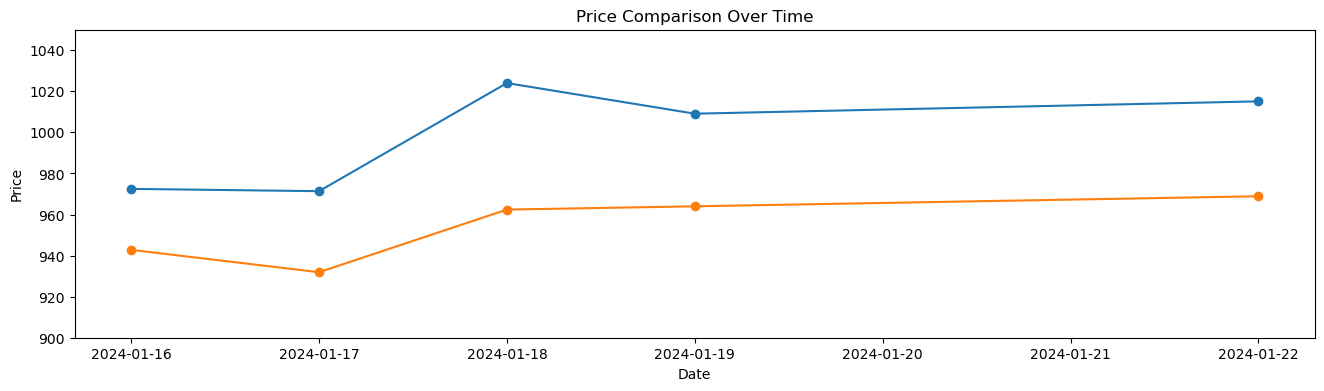

In [38]:
combined_df = retrieve_data()

evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    price_1,
    ylim=(900, 1050)
    )

In [26]:
np.random.seed(42)
n_days = 252
dt = 1 / n_days

close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
close.cov()

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
ROG_Last_Price,375.344673,-17.563543,286.937174
CFR_Last_Price,-17.563543,133.176550,138.191785
ZURN_Last_Price,286.937174,138.191785,706.118284


In [27]:
deltas

{'ROG_Last_Price': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  

In [7]:
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())
log_returns.iloc[186:, :]

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
187,0.014519,-0.016629,0.000000
188,0.030171,0.027811,0.008811
189,-0.002100,-0.011182,0.000000
190,0.000350,0.006352,0.011422
191,0.001050,-0.001864,-0.002274
...,...,...,...
248,-0.001465,-0.006297,-0.002278
249,-0.002568,0.002366,-0.011084
250,0.018202,-0.007115,-0.001538
251,0.009336,0.018861,0.001923


In [ ]:
df_bond = retrieve_bond()